In [2]:
import numpy as np
import pandas as pd
import scipy
import math
from scipy import special
from sympy import symbols, Eq, nsolve, sqrt
from matplotlib import pyplot as plt

# Model Assumptions

In [3]:
# Distribution parameters
v = 7.5

# Asset parameters
Rf = 1 # Gross interest rate
γ_hat = 0.6 # Portfolio risk aversion
σ_M = 0.25 # Volatility of market returns

# Prospect Theory parameters
α = 0.7 # Dimishing sensitivity parameter
δ = 0.65 # Probability weighting parameter
λ = 1.5 # Loss averse parameter
b_hat = 0.6 # Prospect theory term

# Data Inputs

In [4]:
df = pd.read_excel("empirical_input.xls")
inputs = df.iloc[[0, -1]].reset_index(drop = True)
inputs["Capitalisation"] = [0.4, 0.6]

inputs

,Return,StDev,Skew,Overhang,Beta,Capitalisation
0,0.009404,0.368488,2.468040,0.104735,0.842076,0.4
1,-0.002700,0.943178,3.790273,-0.316220,1.126670,0.6


# Parameter Solving

The mean, variance and skewness of the distribution are 
$$\begin{align}
E(\tilde{R_i})=\bar{R_i}&= \mu_i + \frac{v}{v-2}\zeta_i\\
Var(\tilde{R_i}) &= \frac{v}{v-2} S_i + \frac{2v^2}{(v-2)^2(v-4)}\zeta_i^2\\
Skew(\tilde{R_i}) &= \frac{2\zeta_i\sqrt{v(v-4)}}{\sqrt{S_i}(2v\zeta_i^2/S_i+(v-2)(v-4))^{\frac{3}{2}}}\bigg(3(v-2)+\frac{8v\zeta_i^2}{S_i(v-6)}\bigg)
\end{align}$$

In [5]:
def E(μ, ζ):
    """Mean of distribution"""
    mean = μ + (v/(v-2))*ζ
    return mean

def var(ζ, sqrt_S):
    """Variance of distribution"""
    var = (v/(v-2))*(sqrt_S**2) + (2 * (ζ**2) * (v**2)) / (v-4) / ((v-2)**2)
    return var

def skew(ζ, sqrt_S):
    """Skewness of distribution"""
    skew = (3*(v-2)+((8*v*(ζ**2))/(v-6)/((sqrt_S)**2))) * (2*ζ*sqrt(v*(v-4))) / (sqrt_S) / ((2*v*(ζ**2)/(sqrt_S**2)) + (v-2)*(v-4))**(1.5)
    return skew

We need to solve simultaneous equations by finding $S_i$ and $\zeta_i$ such that those values make the distribution have variance and skewness that matches the empirical data of that asset.

In [6]:
def parameter_solver(StDev, Skew):
    """Finds ζ and sqrt_S so that variance and skewness match"""
    ζ1, sqrt_S1 = symbols('ζ1, sqrt_S1') # The variables
    eq1 = Eq(var(ζ1, sqrt_S1), StDev**2) 
    eq2 = Eq(skew(ζ1, sqrt_S1), Skew) 
    result = nsolve([eq1, eq2], [ζ1, sqrt_S1], [1, 1]) # Solve simultaneous equation
    return result

In [7]:
# Create empty arrays
result = np.empty([len(inputs),2])

# Populate arrays with results of parameter_solver
for i in range(len(inputs)):
    result[i:,] = list(parameter_solver(inputs["StDev"][i], inputs["Skew"][i]))

# Create dataframe
column_values = ['ζ', 'sqrt_S']
output = pd.DataFrame(data = result, columns = column_values)

In [8]:
output

,ζ,sqrt_S
0,0.217965,0.250109
1,0.692359,0.528048


# Distributions

Define the increment, the lower limit, and the upper limit for numerical integration

In [27]:
delta_r = 1/300 # Width of increment
lower_limit = -100
upper_limit = 100

num = (upper_limit - lower_limit) / delta_r + 1 # Number of spaces in vector
ret_vec = list(np.linspace(lower_limit, upper_limit, int(num))) # Discretised return vector

M = len(ret_vec) # Length of vector

### Probability Density Function

Each distribution has a one-dimensional generalised hyperbolic skewed t distribution, with density function

$$
p(R_i) = \frac{2^{1-\frac{v+1}{2}}}{\Gamma(\frac{v}{2})(\pi v S_i)^{\frac{1}{2}}}
\cdot \frac{K_{\frac{v+1}{2}}\bigg(\sqrt{(v+(R_i-\mu_i)^2/S_i)\zeta_i^2/S_i)}\bigg)\text{exp}((R_i-\mu_i)\zeta_i/S_i)}{\bigg(\sqrt{(v+(R_i-\mu_i)^2/S_i)\zeta_i^2/S_i)}\bigg)^{-\frac{v+1}{2}}(1+(R_i-\mu_i)^2v^{-1}/S_i)^{\frac{v+1}{2}}}
$$
for $\zeta\neq 0$, and 
$$
p(R_i) = \frac{\Gamma(\frac{v+1}{2})}{\Gamma(\frac{v}{2})(\pi vS_i)^{\frac{1}{2}}}\cdot
(1+(R_i-\mu_i)^2v^{-1}/S_i)^{\frac{v+1}{2}}
$$
for $\zeta_i=0$.

In [28]:
# Create functions of parts of the above function to simplify the next cell

def sqrt_function(R, μ, ζ, sqrt_S):
    """Creating the sqrt part above"""
    result = ((v + (R - μ)**2 / (sqrt_S**2)) * (ζ**2) / (sqrt_S**2))
    return np.sqrt(result).astype(float)

def vplus1_function(R, μ, ζ, sqrt_S):
    """Creating the (v+1)/2 function"""
    result = 1 + ((R - μ)**2 / (sqrt_S**2) / v)
    return result**((v+1)/2)

def gamma_function(sqrt_S):
    """Creating denominator"""
    result = np.pi * v * (sqrt_S**2)
    return scipy.special.gamma(v/2) * result**0.5

def exp_function(R, μ, ζ, sqrt_S):
    """Creating exp part"""
    result = float((R - μ) * ζ / (sqrt_S**2))
    return np.exp(result)

def bessel(R, μ, ζ, sqrt_S):
    '''Creating bessel function'''
    result = scipy.special.kv((v+1)/2, sqrt_function(R, μ, ζ, sqrt_S))
    return float(result)

In [29]:
sqrt_function(1.0,1.0,0.2,0.2)

2.7386127875258306

In [30]:
sqrt_function(1,1,0.2,0.2)

2.7386127875258306

In [31]:
def pdf(R, μ, ζ, sqrt_S):
    """Point by point pdf. This creates the above function taking in a specific R as an argument"""
    if ζ == 0:
        density = scipy.special.gamma((v+1)/2) * vplus1_function(R, μ, ζ, sqrt_S) / gamma_function(sqrt_S)
    else: 
        density = (2**(1-((v+1)/2))) * bessel(R, μ, ζ, sqrt_S) * exp_function(R, μ, ζ, sqrt_S) / gamma_function(sqrt_S) / (sqrt_function(R, μ, sqrt_S, ζ)**(-(v+1)/2)) / vplus1_function(R, μ, ζ, sqrt_S)
    return density

def pdf_total(μ, ζ, sqrt_S):
    """Creating the distribution for an asset with parameters μ, ζ, sqrt_S"""
    outputs = np.array([pdf(R, μ, ζ, sqrt_S) for R in ret_vec])
    return outputs

def cdf_total(μ, ζ, sqrt_S):
    """Creates the CDF for an asset with parameters μ, ζ, sqrt_S"""
    return np.cumsum(pdf_total(μ, ζ, sqrt_S)) * delta_r

# Prospect Theory

The value function is $$v(x)=\begin{cases}x^{\alpha}, & x\geq 0\\-\lambda(-x)^{\alpha},&x<0\end{cases}$$

The probability weighting function is 
$$
w(P)=\frac{P^{\delta}}{(P^{\delta}+(1-P)^{\delta})^{1/\delta}}
$$

The quantity $V(\tilde{G_i})$ is the cumulative prospect theory value of the gain or loss $\tilde{G_i}$. For $\Theta_i>0$, we have 
\begin{align*}
V(\tilde{G_i})&=-\lambda \int\limits_{-\infty}^{R_f-\theta_{i,-1}g_i/\theta_i} (\theta_i(R_f-R_i)-\theta_{i,-1}g_i)^{\alpha} dw(P(R_i))\\&-\int\limits_{R_f-\theta_{i,-1}g_i/\theta_i}^{\infty} (\theta_i(R_i-R_f)+\theta_{i,-1}g_i)^{\alpha} dw(1-P(R_i))
\end{align*}
________________________

The integrated gain/loss for asset $i$ for the cumulative prospect theory term in scaled down objective function
$$
\theta_i(\tilde{R_i}-R_f)+\theta_{i,-1}g_i.
$$

#### Loss: 
We have $$dw(P(R_i))=\frac{dw(P(R_i))}{dP(R_i)}\frac{dP(R_i)}{dR_i}dR_i$$
with 
$$
\frac{dw(P(R_i))}{dP(R_i)}=\frac{\delta P^{\delta -1}(P^{\delta}+(1-P)^{\delta})-P^{\delta}(P^{\delta-1}-(1-P)^{\delta-1})}{(P^{\delta}+(1-P)^{\delta})^{1+\frac{1}{\delta}}}
$$
using $P$ as short-hand for $P(R_i)$
___________

#### Gain:
We have $$dw(1-P(R_i))=\frac{dw(1-P(R_i))}{dP(R_i)}\frac{dP(R_i)}{dR_i}dR_i$$
with 
$$
\frac{dw(1-P(R_i))}{dP(R_i)}=\frac{\delta (1-P)^{\delta -1}(P^{\delta}+(1-P)^{\delta})-(1-P)^{\delta}((1-P)^{\delta-1}-P^{\delta-1})}{(P^{\delta}+(1-P)^{\delta})^{1+\frac{1}{\delta}}}
$$
using $P$ as short-hand for $P(R_i)$
___________

In [32]:
def Gain(R, cgo, θ_M, θ):
    """Gain/loss of asset i given outcome of random variable Ri"""
    return θ * (R - Rf) + θ_M * cgo

def derivative_loss(P):
    """dw(P(R))/d(P(R))"""
    numerator = (δ * P**(δ-1)) * (P**δ + (1-P)**δ) - P**δ * (P**(δ-1) - (1-P)**(δ-1))
    denominator = (P**δ + (1-P)**δ) ** (1+1/δ)
    derivative = numerator / denominator
    return derivative

def derivative_gain(P):
    """dw(1-P(R))/d(P(R))"""
    numerator = (δ * (1-P)**(δ-1)) * (P**δ + (1-P)**δ) - (1-P)**δ * ((1-P)**(δ-1) - P**(δ-1))
    denominator = (P**δ + (1-P)**δ) ** (1 + 1/δ)
    derivative = numerator / denominator
    return derivative

In [35]:
len(ret_vec)

60000

In [33]:
len(pdf_total(1,0.2,0.2))

60000

###  Cumulative Prospect Theory term

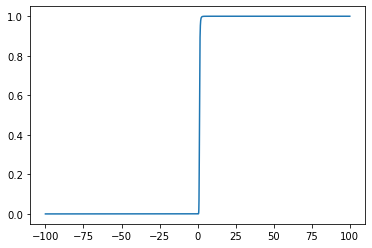

In [38]:
plt.plot(ret_vec,cdf_total(1,0.2,0.2))

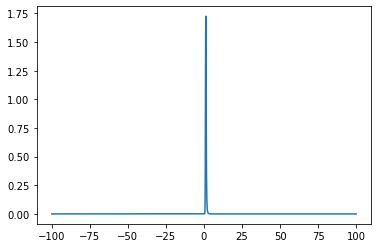

In [37]:
plt.plot(ret_vec,pdf_total(1,0.2,0.2))

In [15]:
def cutoff_index(cgo, θ_M, θ):
    """Returns"""
    cutoff = Rf - cgo * θ_M / θ
    m = min(R for R in ret_vec if R >= cutoff) # minimum value in ret_vec closest to R
    idx = ret_vec.index(m) # Index of m used to find 
    return idx

In [16]:
def CPT(μ, ζ, sqrt_S, cgo, θ_M, θ):
    """Calculates CPT term for asset with parameters above"""
    
    idx = cutoff_index(cgo, θ, θ_M)
    
    pdf = pdf_total(μ, ζ, sqrt_S)
    cdf = cdf_total(μ, ζ, sqrt_S)
   
    # Gains

    gains_skew_dist_pdf = pdf[idx:]
    gains_skew_dist_cdf = cdf[idx:]
    gains_ret_vec_sub = ret_vec[idx:]
    
    gains_vector = [((Gain(R, θ, θ_M, cgo))**α * p * P) 
                    for R, p, P in zip(gains_ret_vec_sub, gains_skew_dist_pdf, gains_skew_dist_cdf)]
    gains = sum(gains_vector) * delta_r
    
    # Losses
    
    losses_skew_dist_pdf = pdf[:idx-1]
    losses_skew_dist_cdf = cdf[:idx-1]
    losses_ret_vec_sub = ret_vec[:idx-1]
    
    losses_vector = [((-λ*(-Gain(R, θ, θ_M, cgo))**α) * p * P) 
                     for R, p, P in zip(losses_ret_vec_sub, losses_skew_dist_pdf, losses_skew_dist_cdf)]
    losses = sum(losses_vector) * delta_r

    return gains + losses

# Solve for initial guess of mu assuming homogeneous holdings

In [17]:
def CPT_theta_epsilon(μ, ζ, sqrt_S, cgo, θ_M, ϵ = 0):
    """Returns the CPT term when an investor chooses θ to be equal to θ_M plus ϵ.
        Note that when ϵ=0, the investor has homogeneous holdings"""
    return CPT(μ, ζ, sqrt_S, cgo, θ_M, θ = (θ_M + ϵ))

The partial derivative of the objective function with respect to $\theta_i$ is 
$$
\begin{align*}
&\mu_i+\frac{v\zeta_i}{v-2}-R_f\\
& - \hat{\gamma}(\theta_i\sigma_i^2 + \beta_i\sigma_M^2 - \theta_{M,i}\sigma_i^2)\\
& +\hat{b} (V(G)')
\end{align*}
$$

In [18]:
def variance_derivative_term(ζ, sqrt_S, β, θ_M):
    """Derives the second line above...Note that θ is set to equal θ_M in this function."""
    return θ_M * var(ζ, sqrt_S) + β * (σ_M**2) - θ_M * var(ζ, sqrt_S)

def objective_derivative(μ, ζ, sqrt_S, cgo, β, θ_M, ϵ = 1/200):
    """Calculates the above"""
    result = E(μ, ζ) - Rf - γ_hat * variance_derivative_term(ζ, sqrt_S, β, θ_M) \
            + b_hat * (CPT_theta_epsilon(μ, ζ, sqrt_S, cgo, θ_M, ϵ) - CPT_theta_epsilon(μ, ζ, sqrt_S, cgo, θ_M, ϵ = 0)) / ϵ
    return result

In [1]:
pdf_total(1,0.2,0.2)

NameError: name 'pdf_total' is not defined

### mu_homogeneous_guess has problems

In [20]:
objective_derivative(1,0.2,0.2,0.1,0.9,0.1)

0.29363956821483245

In [21]:
def mu_homogeneous_guess(ζ, sqrt_S, cgo, β, θ_M, ϵ = 1/200):
    """Finds mu that maximises the objective function given homogeneous holdings"""
    μ1 = symbols('μ1')
    expr = objective_derivative(μ1, ζ, sqrt_S, cgo, β, θ_M, ϵ = 1/200)
    sol = solve(expr)
    return sol

In [ ]:
mu_homogeneous_guess(0,0.2,0.1,0.9,0.1)

# Check if this mu does indeed achieve a maximum

The objective function is 
$$
\begin{align*}
&\theta_i(\mu_i+\frac{v\zeta_i}{v-2}-R_f) - \frac{\hat{\gamma}}{2}(\theta_i^2\sigma_i^2 + 2\theta_i(\beta_i\sigma_M^2-\theta_{M,i}\sigma_i^2))\\
& -\lambda \hat{b}\int\limits_{-\infty}^{R_f-\theta_{i,-1}g_i/\theta_i} (\theta_i(R_f-R_i)-\theta_{i,-1}g_i)^{\alpha}dw(P(R_i))\\
& -\hat{b}\int\limits_{R_f-\theta_{i,-1}g_i/\theta_i}^{\infty}(\theta_i(R_i-R_f)+\theta_{i,-1}g_i)^{\alpha}dw(1-P(R_i))
\end{align*}
$$

In [ ]:
def variance_term(ζ, sqrt_S, β, θ_M, θ):
    """Gives the variance term in objective function"""
    return (θ**2 * var(ζ, sqrt_S)) + 2*θ*(β*(σ_M**2) - θ_M*var(ζ, sqrt_S))

def objective_function(μ, ζ, sqrt_S, cgo, β, θ_M, θ):
    """The objective function for asset i"""
    obt_function = θ * (E(μ, ζ) - Rf) - (γ_hat / 2) * variance_term(ζ, sqrt_S, β, θ_M, θ) \
                    + b_hat * CPT(μ, ζ, sqrt_S, cgo, θ_M, θ)
    return obt_function

### value_vec is too slow

In [ ]:
def theta_vec(θ_M, upper_limit = 0.8, n = 10):
    """Creates vector from θ_M/25 to upper_limit with n numbers in vec"""
    vec = list(np.linspace(θ_M/25, upper_limit, n))
    return vec

def value_vec_solved_mu(ζ, sqrt_S, cgo, β, θ_M, μ):
    """Stores values of the objective function when θ goes from θ_M/25 to 0.8"""
    
    # mu = mu_homogeneous_guess(ζ, sqrt_S, cgo, β, θ_M, ϵ = 1/200) # Using the solved mu from above
    
    return [objective_function(ζ, sqrt_S, cgo, β, θ_M, theta, μ) for theta in theta_vec(θ_M)]

In [ ]:
def V_0(cgo, θ_M):
    """V_0 is the value of the objective function when θ is set to zero"""
    if cgo >= 0:
        V0 = b_hat * (cgo * θ_M)**α
    else:
        V0 = b_hat * (-λ) * (-cgo * θ_M)**α
    return V0

Below will need work

In [ ]:
def homogeneous(μ, ζ, sqrt_S, cgo, β, θ_M, θ):
    
    mu = [] # mu mu_homogeneous guess if the equilibrium is heterogeneous
    hom_holdings = [] # 1 indicates that the equilibrium is of homogeneous holdings
    
    solved_mu = mu_homogeneous_guess(ζ, sqrt_S, cgo, β, θ_M)
    obj_fun = objective_function(ζ, sqrt_S, cgo, β, θ_M, μ = solved_mu, θ = θ_M)
    
    V0 = V_0(cgo, θ_M)
    vec_max = max(value_vec_solved_mu)
    max_V = max(V0, vec_max)
    
    if abs(obj_fun - max_V) >= 1/2000:
        mu = solved_mu
        hom_holdings = 0
        # Heterogeneous holdings
    elif V0 > value_vec_solved_mu[0]:
        mu = solved_mu
        hom_holdings = 0
        # Heterogeneous holdings
    elif V0 > obj_fun:
        mu = solved_mu
        hom_holdings = 0
        # Heterogeneous holdings
    else:
        mu = []
        hom_holdings = 1
        # Homogeneous holdings
        
    # mu is mu_homogeneous guess if the equilibrium is heterogeneous
    # Homogeneous holdings is 1 if the equilibrium is of homogeneous holdings   
    
    return mu, hom_holdings 

In [ ]:
value_vec(1,2,3,0.1,0.9,0.1)

In [ ]:
delta_r = 1/400 # Width of increment
lower_limit = -100
upper_limit = 100

num = (upper_limit - lower_limit) / delta_r + 1 # Number of spaces in vector
ret_vec = list(np.linspace(lower_limit, upper_limit, int(num))) # Discretised return vector

M = len(ret_vec) # Length of vector

In [ ]:
solved_μ = mu_homogeneous_guess(ζ, sqrt_S, cgo, β, θ_M)

pdf = pdf_total(μ = solved_μ, ζ, sqrt_S)
cdf = cdf_total(μ = solved_μ, ζ, sqrt_S)

